### Takes all incidents from 2010 and fits to possion distribution

In [38]:
import pandas as pd

In [73]:
incidents=pd.read_csv('5e842a5d-9ce0-40ae-8c97-604e5ce153d1.csv')

In [74]:
incidents.describe()

,Region,Hour(HH.MM),Hour(HH.H)
count,0.0,88201.000000,88201.000000
mean,NaN,12.955834,13.161597
std,NaN,4.954652,4.958253
min,NaN,0.000000,0.000000
25%,NaN,9.030000,9.100000
50%,NaN,13.310000,13.500000
75%,NaN,17.030000,17.100000
max,NaN,23.590000,24.000000


In [75]:
incidents

,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H)
0,"145.242458668,-17.6613188854",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,11/08/2010 10:20,No Blockage,10.20,10.3
1,"145.496414185,-17.6104373932",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,22/10/2010 16:04,Partially Blocked,16.04,16.1
2,"153.010772705,-27.4678230286",BOOMERANG STREET,NaN,Stationary Vehicle,1/01/2011 1:33,Unknown,1.33,1.6
3,"153.069381714,-27.5534038544",PACIFIC MOTORWAY,NaN,Stationary Vehicle,1/01/2011 1:46,Unknown,1.46,1.8
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9
5,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Hazard,1/01/2011 2:32,Unknown,2.32,2.5
6,"153.409698486,-27.9616641998",NORTH STREET,NaN,Crash,1/01/2011 2:34,Unknown,2.34,2.6
7,"153.351165771,-28.026714325",PACIFIC HIGHWAY,NaN,Stationary Vehicle,1/01/2011 2:59,Unknown,2.59,3.0
8,"153.055099487,-26.7745513916",CALOUNDRA ROAD,NaN,Hazard,1/01/2011 4:55,Unknown,4.55,4.9
9,"153.334594727,-27.9911365509",WHITE STREET,NaN,Planned Event/Roadworks,1/01/2011 5:09,Unknown,5.09,5.2


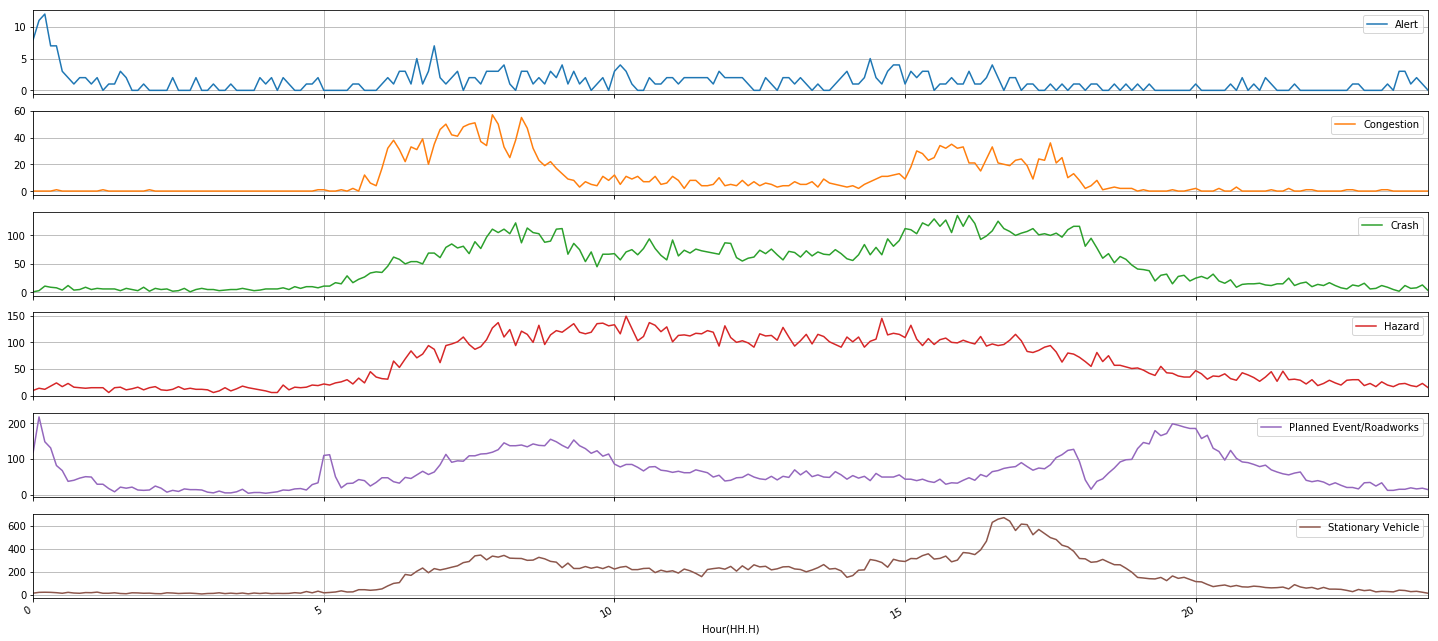

In [95]:
incidents.pivot_table(
    index = 'Hour(HH.H)',
    columns ='type',
    values='blockagetype',
   aggfunc=len, fill_value=0).plot(subplots=True, figsize=(25,12), grid= True);


,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H),Counts
0,"145.242458668,-17.6613188854",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,11/08/2010 10:20,No Blockage,10.20,10.3,150.0
1,"145.496414185,-17.6104373932",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,22/10/2010 16:04,Partially Blocked,16.04,16.1,87.0
2,"153.010772705,-27.4678230286",BOOMERANG STREET,NaN,Stationary Vehicle,1/01/2011 1:33,Unknown,1.33,1.6,44.0
3,"153.069381714,-27.5534038544",PACIFIC MOTORWAY,NaN,Stationary Vehicle,1/01/2011 1:46,Unknown,1.46,1.8,33.0
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9,34.0


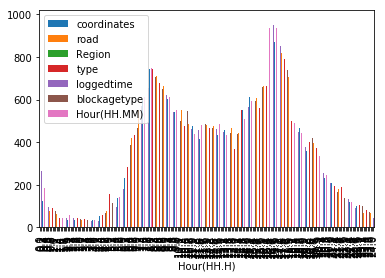

In [14]:
test.plot(kind='bar')

In [15]:
crashes = incidents['type'] ='Crash'

In [16]:
crashes

'Crash'

In [17]:
incidents

,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H)
0,"145.242458668,-17.6613188854",KENNEDY HIGHWAY,NaN,Crash,11/08/2010 10:20,No Blockage,10.20,10.3
1,"145.496414185,-17.6104373932",KENNEDY HIGHWAY,NaN,Crash,22/10/2010 16:04,Partially Blocked,16.04,16.1
2,"153.010772705,-27.4678230286",BOOMERANG STREET,NaN,Crash,1/01/2011 1:33,Unknown,1.33,1.6
3,"153.069381714,-27.5534038544",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:46,Unknown,1.46,1.8
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9
5,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 2:32,Unknown,2.32,2.5
6,"153.409698486,-27.9616641998",NORTH STREET,NaN,Crash,1/01/2011 2:34,Unknown,2.34,2.6
7,"153.351165771,-28.026714325",PACIFIC HIGHWAY,NaN,Crash,1/01/2011 2:59,Unknown,2.59,3.0
8,"153.055099487,-26.7745513916",CALOUNDRA ROAD,NaN,Crash,1/01/2011 4:55,Unknown,4.55,4.9
9,"153.334594727,-27.9911365509",WHITE STREET,NaN,Crash,1/01/2011 5:09,Unknown,5.09,5.2


In [19]:
crash_counts =incidents.groupby('Hour(HH.H)').count()

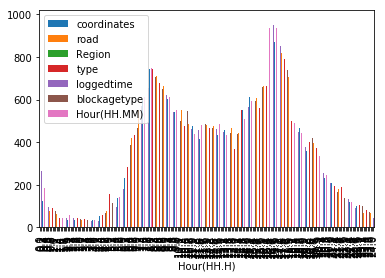

In [20]:
crash_counts.plot(kind='bar')

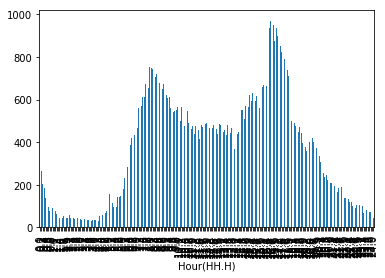

In [23]:
crash_counts['Hour(HH.MM)'].plot(kind='bar')

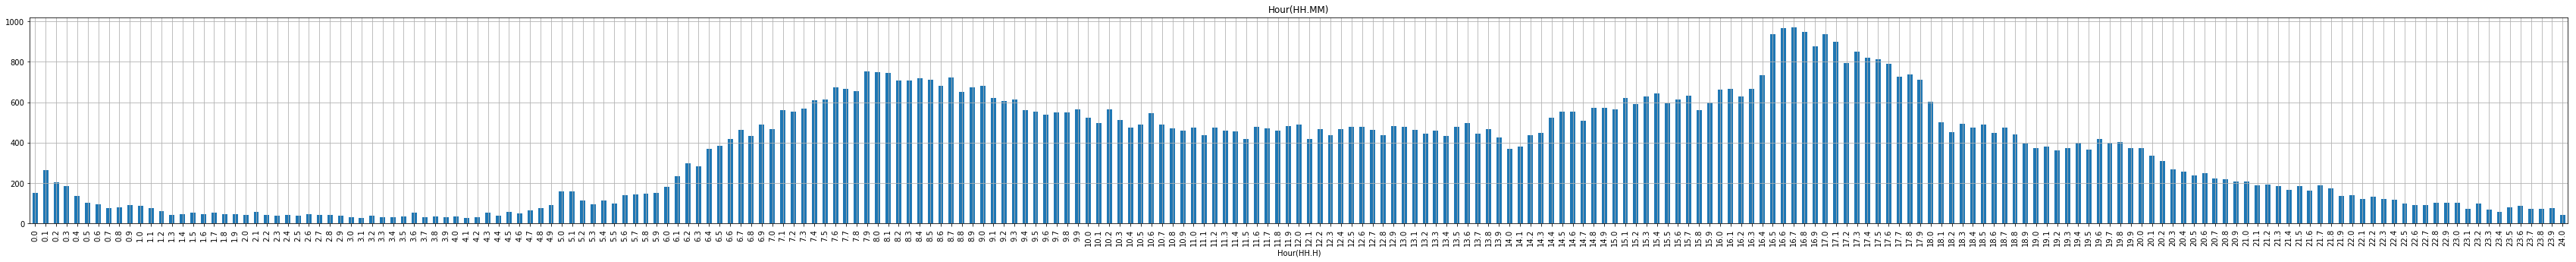

In [27]:
crash_counts['Hour(HH.MM)'].plot(kind='bar',subplots=True, figsize=(60,5), grid= True);

In [33]:
crash_counts=crash_counts['Hour(HH.MM)']


KeyError: 'Hour(HH.MM)'

In [ ]:
crash_counts.pivot_table(
    columns ='sex',
    values=['whole weight','shucked weight'], 
    aggfunc='median').plot(subplots=True, figsize=(10,12), grid= True);

In [34]:
crash_counts

Hour(HH.H)
0.0     150
0.1     264
0.2     203
0.3     184
0.4     138
0.5     103
0.6      94
0.7      75
0.8      80
0.9      93
1.0      87
1.1      75
1.2      63
1.3      42
1.4      46
1.5      53
1.6      46
1.7      55
1.8      47
1.9      45
2.0      44
2.1      57
2.2      42
2.3      39
2.4      42
2.5      39
2.6      47
2.7      42
2.8      43
2.9      38
       ... 
21.1    191
21.2    194
21.3    187
21.4    166
21.5    185
21.6    162
21.7    191
21.8    175
21.9    138
22.0    140
22.1    120
22.2    133
22.3    121
22.4    117
22.5    100
22.6     93
22.7     91
22.8    103
22.9    103
23.0    103
23.1     72
23.2    101
23.3     70
23.4     58
23.5     81
23.6     89
23.7     72
23.8     72
23.9     76
24.0     44
Name: Hour(HH.MM), Length: 241, dtype: int64

In [36]:
incidents['Count']= crash_counts

In [37]:
incidents

,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H),Count
0,"145.242458668,-17.6613188854",KENNEDY HIGHWAY,NaN,Crash,11/08/2010 10:20,No Blockage,10.20,10.3,150.0
1,"145.496414185,-17.6104373932",KENNEDY HIGHWAY,NaN,Crash,22/10/2010 16:04,Partially Blocked,16.04,16.1,87.0
2,"153.010772705,-27.4678230286",BOOMERANG STREET,NaN,Crash,1/01/2011 1:33,Unknown,1.33,1.6,44.0
3,"153.069381714,-27.5534038544",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:46,Unknown,1.46,1.8,33.0
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9,34.0
5,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 2:32,Unknown,2.32,2.5,159.0
6,"153.409698486,-27.9616641998",NORTH STREET,NaN,Crash,1/01/2011 2:34,Unknown,2.34,2.6,182.0
7,"153.351165771,-28.026714325",PACIFIC HIGHWAY,NaN,Crash,1/01/2011 2:59,Unknown,2.59,3.0,469.0
8,"153.055099487,-26.7745513916",CALOUNDRA ROAD,NaN,Crash,1/01/2011 4:55,Unknown,4.55,4.9,747.0
9,"153.334594727,-27.9911365509",WHITE STREET,NaN,Crash,1/01/2011 5:09,Unknown,5.09,5.2,682.0


In [ ]:
abalone.pivot_table(
    index='rings',
    columns ='sex',
    values=['whole weight','shucked weight'], 
    aggfunc='median').plot(subplots=True, figsize=(10,12), grid= True);